In [ ]:
from wtlike import *

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

`wtlike` is on PyPI

```
pip install wtlike
```
We use a simulated on-the-fly dataset in lieu of downloading the 2-GB file with all of fermi data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- exposure rate -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, time_bins=(0,0,1))

generated 18719 photons
WtLike: Source flare_sim with:
	 data:        18,719 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average rate 3000 cm^2 for 2.6 Ms
	 rates:  source 1.41e-06/s, background 1.00e-06/s, S/N ratio 1.41
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>10 & n>2


Now make a light curve!

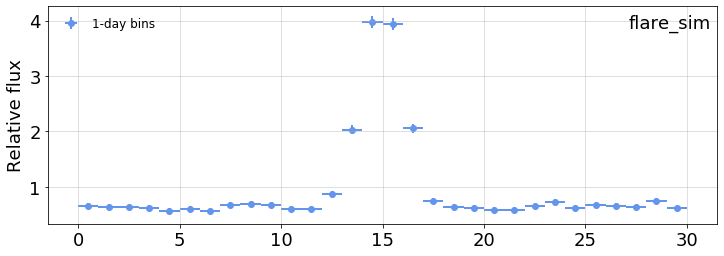

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation for each. The first few cells are:

In [ ]:
daily.cells.head(2)

t   tw      e    n                                                  w  \
0  0.5  1.0  258.3  545  [0.045838855, 0.017929373, 0.003666568, 0.0297...   
1  1.5  1.0  259.2  524  [0.42117244, 0.8847942, 0.0033767915, 0.364480...   

        S       B  
0  363.58  258.22  
1  364.85  259.12

The Kerr likelihood function is definded by $w$, the list of weights, and $S$, an estimate for the signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the varation from the nominal zero. The backgrond is assumed to be constant here, as it usually is the region surrounding sources of interest. 
So the relative flux is $1+\alpha$. 

Parmeters of this function are determined by fitting it to a Poisson-like function, which easily provides the parameters of interest.

In [ ]:
daily.fluxes.head(2)

t   tw    n     ts  flux           errors  limit
0  0.5  1.0  545  406.0  0.65   (-0.05, 0.051)   0.74
1  1.5  1.0  524  384.1  0.63  (-0.049, 0.051)   0.72

Note that the properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). So we can find a fit at the peak with a `query`.

In [ ]:
daily.fluxes.query('flux>3')

t   tw     n      ts  flux           errors  limit
14  14.5  1.0  1606  9644.3  3.97  (-0.106, 0.107)   4.15
15  15.5  1.0  1598  9648.8  3.94  (-0.105, 0.107)   4.11

## Views
A `WtLike` object provides a function `view`, which returns a **new** instance with a different binning. 
So if we want a detailed look at the flare, we can choose an interval as so:

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>10 & n>2


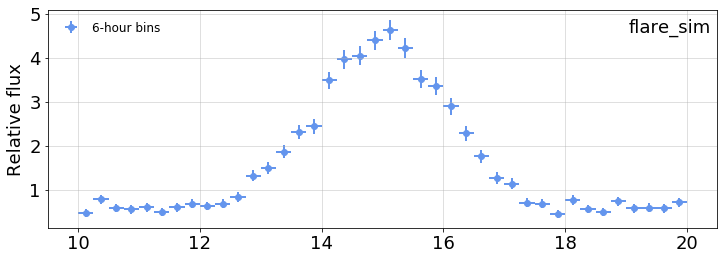

In [ ]:
qday = daily.view((10,-10, 0.25))
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis.  

LightCurve: select 40 cells for fitting with e>10 & n>2
Partitioned 40 cells into 9 blocks, using LikelihoodFitness 
LightCurve: Loaded 9 / 9 cells for fitting


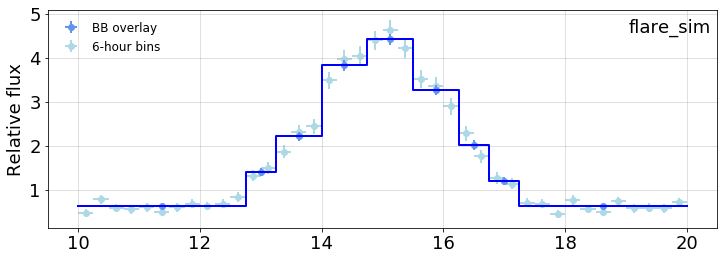

In [ ]:
bb = qday.bb_view();bb.plot();

This has created variable-sized cells, the fits for which are shown here:

In [ ]:
bb.fluxes

t    tw     n      ts  flux           errors  limit
0  11.38  2.75  1439  1078.7  0.63    (-0.03, 0.03)   0.68
1  13.00  0.50   372   847.5  1.41  (-0.093, 0.096)   1.57
2  13.62  0.75   756  2805.6  2.21  (-0.093, 0.095)   2.37
3  14.38  0.75  1170  6832.2  3.83   (-0.12, 0.122)   4.04
4  15.12  0.75  1324  8539.5  4.42   (-0.128, 0.13)   4.64
5  15.88  0.75  1023  5393.7  3.26  (-0.111, 0.113)   3.45
6  16.50  0.50   479  1606.8  2.02  (-0.109, 0.112)   2.21
7  17.00  0.50   333   672.3  1.20   (-0.086, 0.09)   1.36
8  18.62  2.75  1416  1083.1  0.62   (-0.029, 0.03)   0.67

### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_flux=1e-06,
    efun=3000,
    wt_signif=0.1,
)
Docstring:      <no docstring>
Init docstring:
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_flux : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : now the width of the PSF in (r/rmax)**2 coordinates
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- pos

The three WtLike methods have help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring: Make a light curve plot
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/main.py
Type:      function


In [ ]:
WtLike.view?

Signature: WtLike.view(self, newbins=None)
Docstring:
Return a "view": a new instance of this class with a perhaps a different set of cells

- newbins -- a tuple (start, stop, step) to define new binning.
  - start and stop are either MJD values, or offsets from the start or stop.
  - step -- the cell size in days, or if zero, orbit-based binning
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


### Using *fermi* data.

The only change from above is that one uses `PointSource` instead of `Simulation`. 

The data must be available, of course.
So,

In [ ]:
check_data()

Weekly folder "/home/burnett/wtlike_data/data_files" contains 666 weeks,  9 to 675, end at 2021-05-13


Get a source: this name can be anything recognized by `astropy.coordinates.SkyCoord`, including all 4FGL sources


In [ ]:
source = PointSource('3C 279'); source

Source "3C 279" at: (l,b)=(305.104,57.062)

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.
All are available in a 2-GB zip file.

In [ ]:
wtl = WtLike(source)

SourceData: photons and exposure for 3C 279: Restoring from cache with key "3C 279_data"
WtLike: Source 3C 279 with:
	 data:       179,695 photons from 2008-08-04 to 2021-04-21
	 exposure: 2,817,749 intervals,  average rate 2935 cm^2 for 84.1 Ms
	 rates:  source 4.03e-07/s, background 3.25e-07/s, S/N ratio 1.24
CellData: Bin photon data into 663 1-week bins from 54683.0 to 59324.0
LightCurve: select 655 cells for fitting with e>10 & n>2


If the the data for this source has not been accessed on this machine before, it must be extracted, a process that takes some 10 min. Otherwise it is a few seconds.

Generate the (default weekly) light curve:

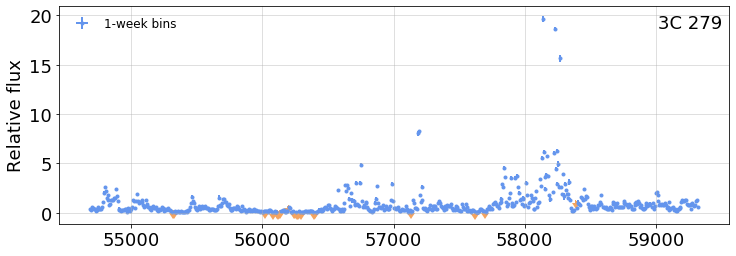

In [ ]:
wtl.plot();